# Options Strategies

## Content

- [Neutral Strategies](#Neutral-Strategies)
    - [Short Straddle](#short-straddle)
    - [Short Strangle](#short-strangle)
    - [Long butterfly spread with calls](#Long-butterfly-spread-with-calls)
    - [Long butterfly spread with puts](#Long-butterfly-spread-with-puts)
    - [Long Christmas tree spread with calls](#Long-Christmas-tree-spread-with-calls)
    - [Long Christmas tree spread with puts](#Long-Christmas-tree-spread-with-puts)
    - [Long calendar spread with calls](#Long-calendar-spread-with-calls)
- [Volatility Strategies](#Volatility-Strategies)
    - [Long Straddle](#Long-Straddle)
    - [Long Strangle](#Long-Strangle)
    - [Short butterfly spread with puts](#Short-butterfly-spread-with-puts)
    - [Short butterfly spread with calls](#Short-butterfly-spread-with-calls)
    - [Short Christmas tree spread with calls](#Short-Christmas-tree-spread-with-calls)
     - [Short Christmas tree spread with puts](#Short-Christmas-tree-spread-with-puts)
    - [Short calendar spread with calls](#Short-calendar-spread-with-calls)
    - [Short condor spread with calls](#Short-condor-spread-with-calls)
    - [Short condor spread with puts](#Short-condor-spread-with-puts)
- [Bearish Strategies](#Bearish-Strategies)
    - [Bear put spread](#Bear-Put-Spread)
    - [Bear call spread](#Bear-call-Spread)
    - [1x2 ratio volatility spread with puts](#1x2-ratio-volatility-spread-with-puts)
    - [Short skip-strike butterfly spread with puts](#Short-skip-strike-butterfly-spread-with-puts)
- [Bullish Strategies](#Bullish-Strategies)
    - [Bull call spread](#Bear-call-Spread)
    - [Bull put spread](#Bear-put-Spread)
    - [1x2 ratio volatility spread with calls](#1x2-ratio-volatility-spread-with-calls)
    - [Short skip-strike butterfly spread with calls](#Short-skip-strike-butterfly-spread-with-calls)

In [1]:
import datetime as dt
from typing import Tuple

import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm

import matplotlib.pyplot as plt

### Notation 

$ K \hspace{10mm} \text{the strike price of an option}\\ $

$ S \hspace{10mm} \text{the price of the underlying}\\ $

$ payoff(call)= \max (S - K,0) \\ $

$ payoff(put) = \max(K - S, 0) $

In [2]:
def payoff_call(sT,x):
    return max(0, sT - x)

def payoff_put(sT,x):
    return max(0, x - sT)

def pl_call(sT,x, c):
    return max(-c, sT - x - c)

def pl_put(sT, x, p):
    return max(-p, x - sT - p)

In [3]:
v_pl_call = np.vectorize(pl_call)
v_pl_put = np.vectorize(pl_put)

In [4]:
payoff_call(20,30)

0

In [5]:
payoff_call(30,20)

10

In [6]:
def get_d1_d2(S, X, T, t, r, sigma) -> Tuple[np.single, np.single]:
    """
    Compute d1 and d2 values for the black-scholes pricing model


    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate
    :param sigma: underlying volatility
    :return: (d1, d2)
    """
    d1 = (np.log(S / X) + (r + sigma * sigma / 2.) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    return d1, d2


def black_scholes(S, X, T, t, r, sigma, o_type: str = "C") -> np.single:
    """
    Compute option price using the black-scholes model

    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate (in percentual)
    :param sigma: underlying volatility
    :param o_type: option type, "C" for a call option and "P" for a put option
    :return: the black-scholes option price
    """
    d1, d2 = get_d1_d2(S, X, T, t, r, sigma)
    if o_type == "C":
        return S * stats.norm.cdf(d1, 0, 1) - X * np.exp(-r * (T - t)) * stats.norm.cdf(d2, 0, 1)
    else:
        return X * np.exp(-r * (T - t)) * stats.norm.cdf(-d2, 0, 1) - S * stats.norm.cdf(-d1, 0, 1)


def delta(S, X, T, t, r, sigma, o_type: str = "C") -> np.single:
    """
    Compute option's delta

    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate (in percentual)
    :param sigma: underlying volatility
    :param o_type: option type, "C" for a call option and "P" for a put option
    :return: the option's delta
    """
    d1, _ = get_d1_d2(S, X, T, t, r, sigma)
    if o_type == "C":
        return stats.norm.cdf(d1)
    else:
        return stats.norm.cdf(d1) - 1


def gamma(S, X, T, t, r, sigma) -> np.single:
    """
    Compute the option's gamma

    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate (in percentual)
    :param sigma: underlying volatility
    :return: the option's gamma
    """
    d1, _ = get_d1_d2(S, X, T, t, r, sigma)
    return stats.norm.pdf(d1) / (S * sigma * np.sqrt(T - t))


def vega(S, X, T, t, r, sigma):
    """
    Compute the option's vega

    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate (in percentual)
    :param sigma: underlying volatility
    :return: the option's vega
    """
    d1, _ = get_d1_d2(S, X, T, t, r, sigma)
    return S * stats.norm.pdf(d1) * np.sqrt(T - t)


def theta(S, X, T, t, r, sigma, o_type: str = "C") -> np.single:
    """
    Compute the option's theta

    :param S: underlying price
    :param X: option's strike price
    :param T: option's time to maturity (in years)
    :param t: current time (in years)
    :param r: interest rate (in percentual)
    :param sigma: underlying volatility
    :param o_type: option type, "C" for a call option and "P" for a put option
    :return: the option's theta
    """
    d1, d2 = get_d1_d2(S, X, T, t, r, sigma)
    tmp_1 = - (S * stats.norm.pdf(d1) * sigma) / (2 * np.sqrt(T - t))
    if o_type == "C":
        return tmp_1 - r * X * np.exp(-r * (T - t)) * stats.norm.cdf(d2)
    else:
        return tmp_1 + r * X * np.exp(-r * (T - t)) * stats.norm.cdf(-d2)

Grafico dei payoff

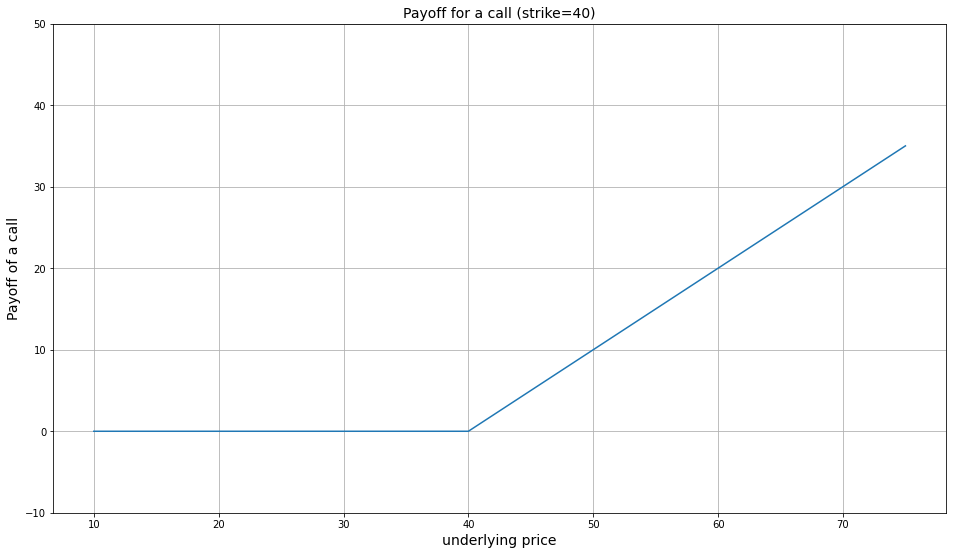

In [7]:
font = {'color':  'black',
        'weight': 'normal',
        'size': 14,
        }

s = np.arange(10,80,5)
x=40
payoff=(abs(s-x)+s-x)/2
plt.figure(figsize=(16,9))
plt.ylim(-10,50)
plt.plot(s,payoff)
plt.title("Payoff for a call (strike=40)", fontdict=font)
plt.xlabel("underlying price", fontdict=font)
plt.ylabel("Payoff of a call", fontdict=font)
plt.grid(True)
plt.show()

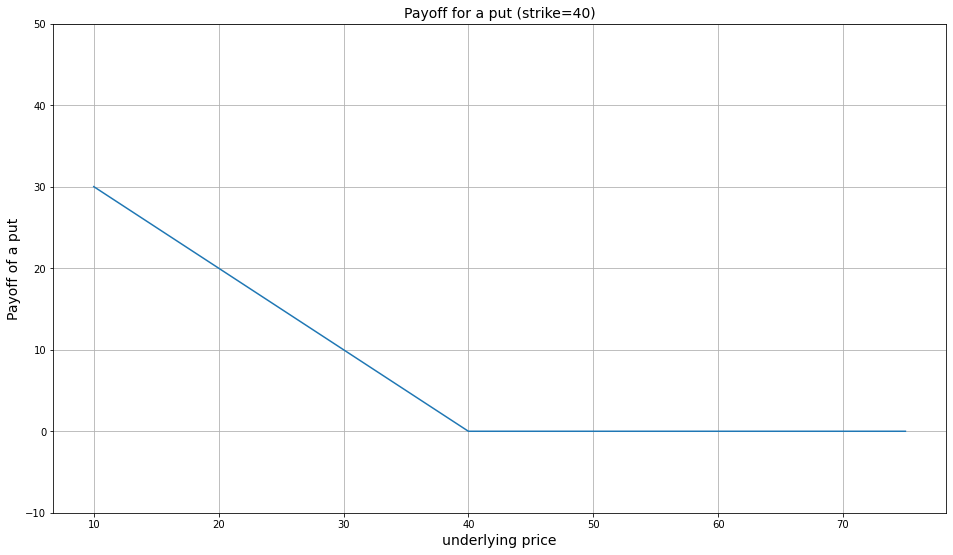

In [8]:
s = np.arange(10,80,5)
x=40
payoff=(abs(x-s)+x-s)/2
plt.figure(figsize=(16,9))
plt.ylim(-10,50)
plt.plot(s,payoff)
plt.title("Payoff for a put (strike=40)", fontdict=font)
plt.xlabel("underlying price", fontdict=font)
plt.ylabel("Payoff of a put", fontdict=font)
plt.grid(True)
plt.show()

####  Profit and loss from the buying and selling of a call option

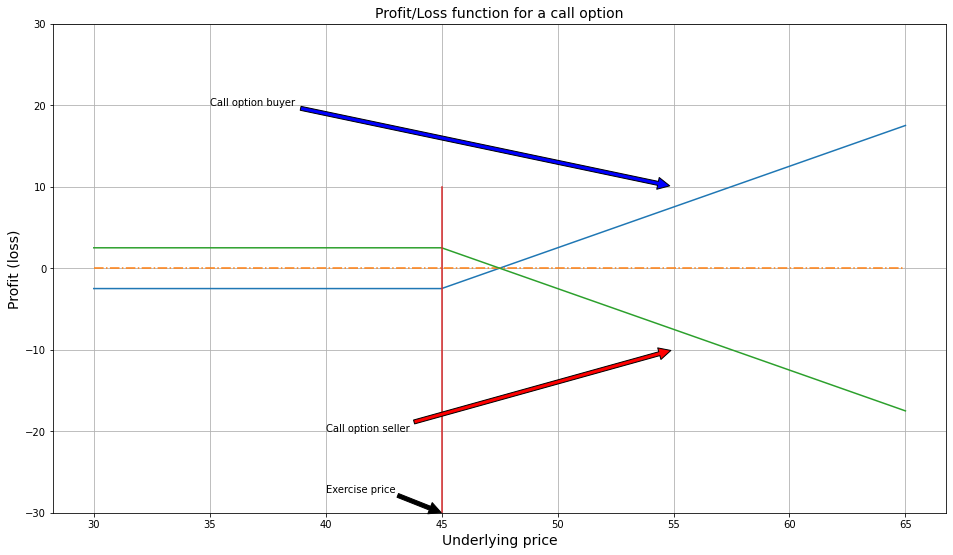

In [9]:
s = np.arange(30,70,5)
x = 45; c = 2.5
y = v_pl_call(s, x, c)
y2 = np.zeros(len(s))
x3 = [x, x]
y3 = [-30,10]
plt.figure(figsize = (16,9))
plt.ylim(-30,30)
plt.plot(s,y)
plt.plot(s,y2,'-.')
plt.plot(s,-y)
plt.plot(x3,y3)
plt.title("Profit/Loss function for a call option", fontdict=font)
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.annotate('Call option buyer', xy=(55,10), xytext=(35,20),
             arrowprops=dict(facecolor='blue',shrink=0.01))
plt.annotate('Call option seller', xy=(55,-10), xytext=(40,-20),
             arrowprops=dict(facecolor='red',shrink=0.01))
plt.annotate('Exercise price', xy=(45,-30), xytext=(40,-27.5), 
             arrowprops=dict(facecolor='black',shrink=0.01))
plt.grid(True)
plt.show()

####  Profit and loss from the buying and selling of a put option

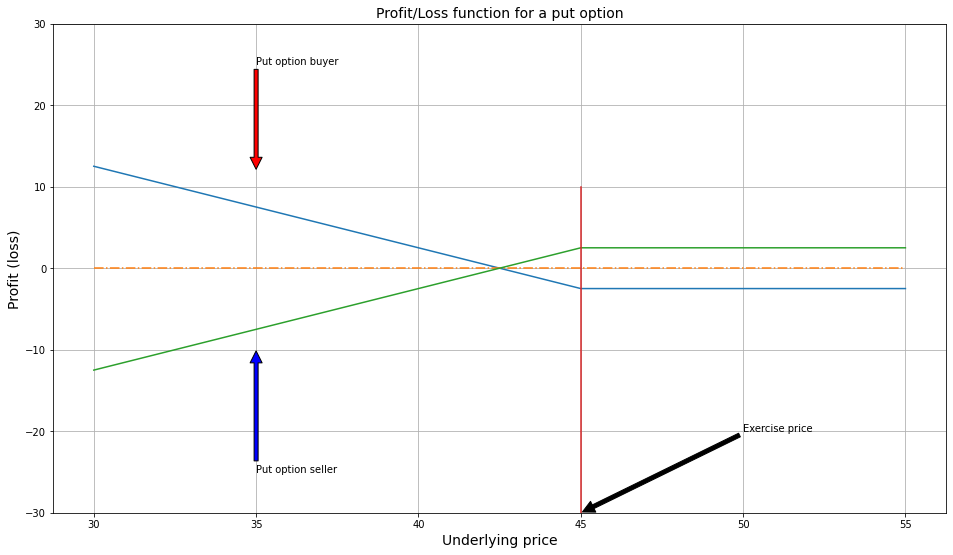

In [10]:
s = np.arange(30,60,5)
x = 45; p = 2.5
y = v_pl_put(s, x, p)
y2=np.zeros(len(s))
plt.figure(figsize=(16,9))
x3=[x, x]
y3=[-30,10]
plt.ylim(-30,30)
plt.plot(s,y) 
plt.plot(s,y2,'-.') 
plt.plot(s,-y) 
plt.plot(x3,y3)
plt.title("Profit/Loss function for a put option", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.annotate('Put option buyer', xy=(35,12), xytext=(35,25), arrowprops=dict(facecolor='red',shrink=0.01),)
plt.annotate('Put option seller', xy=(35,-10), xytext=(35,-25), arrowprops=dict(facecolor='blue',shrink=0.01),)
plt.annotate('Exercise price', xy=(45,-30), xytext=(50,-20), arrowprops=dict(facecolor='black',shrink=0.01),)
plt.grid(True)
plt.show()

# Neutral Strategies

## Short Straddle

### Strategy

The straddle option strategy involves either buying the exact same strike price call and put or selling the exact same strike price call and put of a given an underlying security.

### When to use it

When you're buying both a call and a put at the same strike price you're trading a long Staddle, while if you're selling both a call and a put a the strike price you're trading a short Straddle. 

Long straddle are often traded when traders predict high volatility for the underlying, ....

### Max Profit

### Max risk

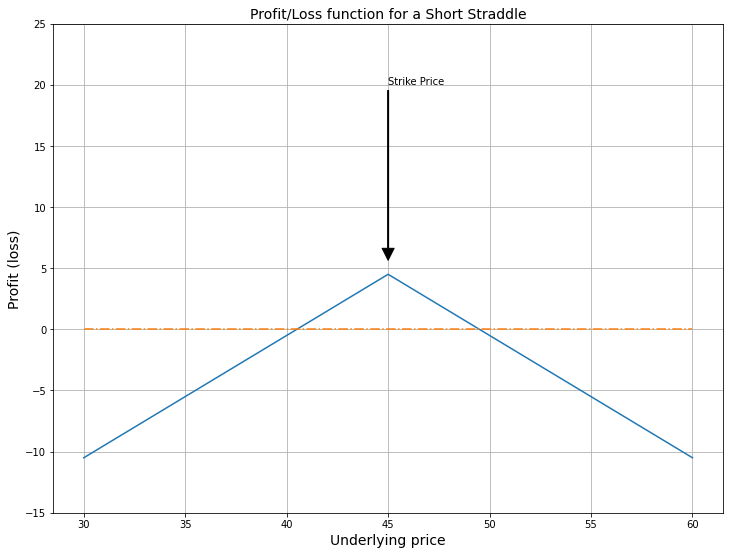

In [11]:
s = np.arange(30,65,5)
x = 45; p = 2.5; c = 2
y = -v_pl_call(s, x, c) - v_pl_put(s, x, p) 
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-15,25)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short Straddle", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.annotate('Strike Price', xy=(45,(p+c) + 1), xytext=(45,20), arrowprops=dict(
    facecolor='black',
    shrink=0.01, 
    width=1),)
plt.grid(True)
plt.show()

## Strangle

### Strategy

The straddle option strategy involves either buying the exact same strike price call and put or selling the exact same strike price call and put of a given an underlying security.

### When to use it

When you're buying both a call and a put at the same strike price you're trading a long Staddle, while if you're selling both a call and a put a the strike price you're trading a short Straddle. 

Long straddle are often traded when traders predict high volatility for the underlying, ....

### Max Profit

### Max risk

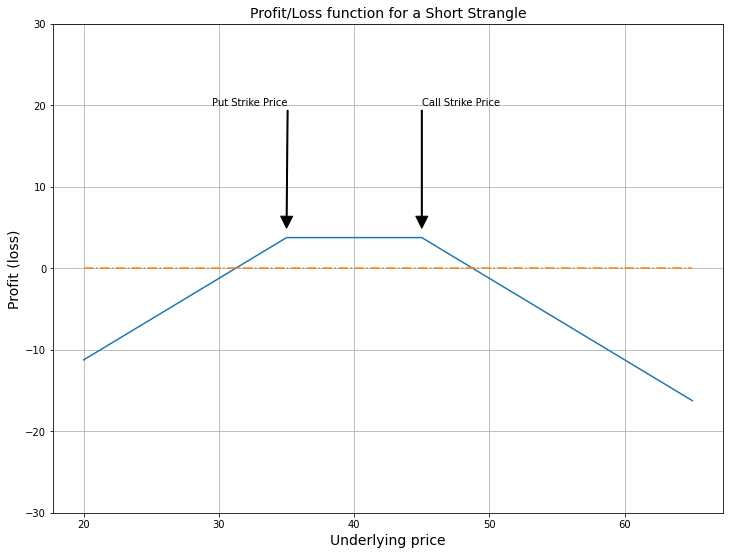

In [12]:
s = np.arange(20,70,5)
x1 = 45; x2 = 35; p = 2; c = 1.75
y = -v_pl_call(s, x1, c) - v_pl_put(s, x2, p) 
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-30,30)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short Strangle", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.annotate('Call Strike Price', xy=(45,(p+c) + 1), xytext=(45,20), 
             arrowprops=dict(
                 facecolor='black',
                 shrink=0.01, 
                 width=1),)
plt.annotate('Put Strike Price', 
             xy=(35,(p+c) + 1), 
             xytext=(29.5,20), 
             arrowprops=dict(
                 facecolor='black',
                 shrink=0.01, 
                 width=1),)
plt.grid(True)
plt.show()

## 1x2 ratio vertical spread with calls

### Strategy

### When to use

### Max profit

### Max risk

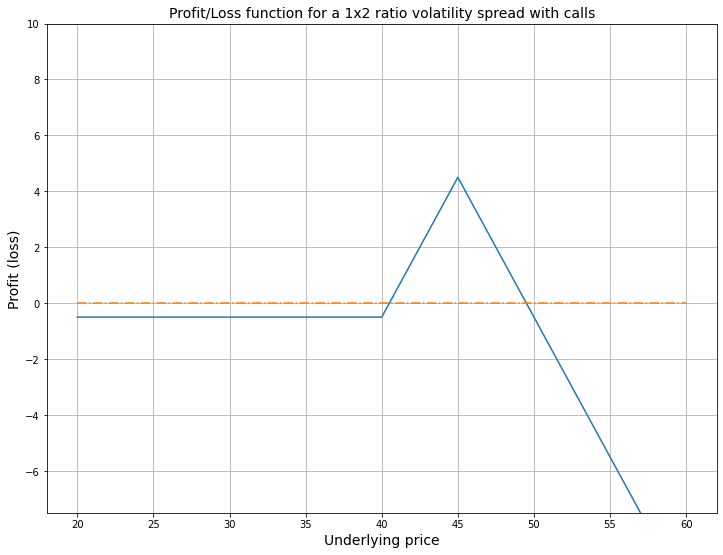

In [13]:
s = np.arange(20,65,5)
x1 = 40; x2 = 45;
c1 = 3.50; c2 = 1.5;
y = v_pl_call(s, x1, c1) - 2 * v_pl_call(s, x2, c2)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-7.5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a 1x2 ratio volatility spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## 1x2 ratio vertical spread with puts

### Strategy

### When to use

### Max profit

### Max risk

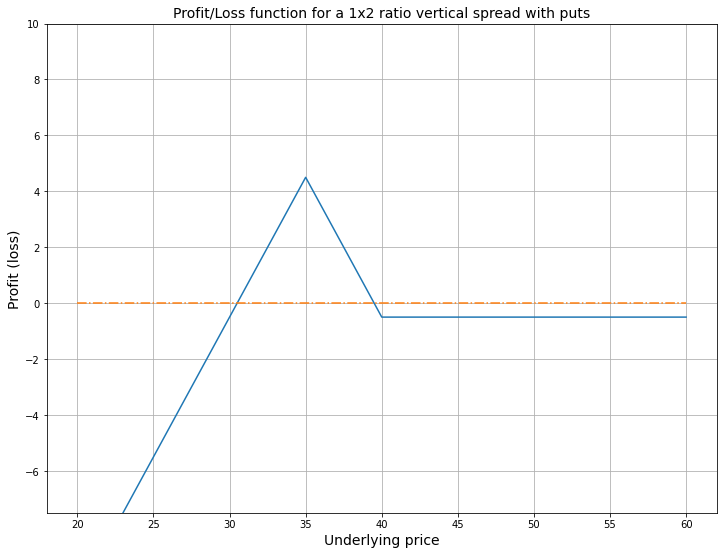

In [14]:
s = np.arange(20,65,5)
x1 = 35; x2 = 40;
p1 = 1.5; p2 = 3.5;
y = - 2 * v_pl_put(s, x1, p1) + v_pl_put(s, x2, p2)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-7.5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a 1x2 ratio vertical spread with puts", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Long butterfly spread with calls

### Strategy

### When to use

### Max profit

### Max risk

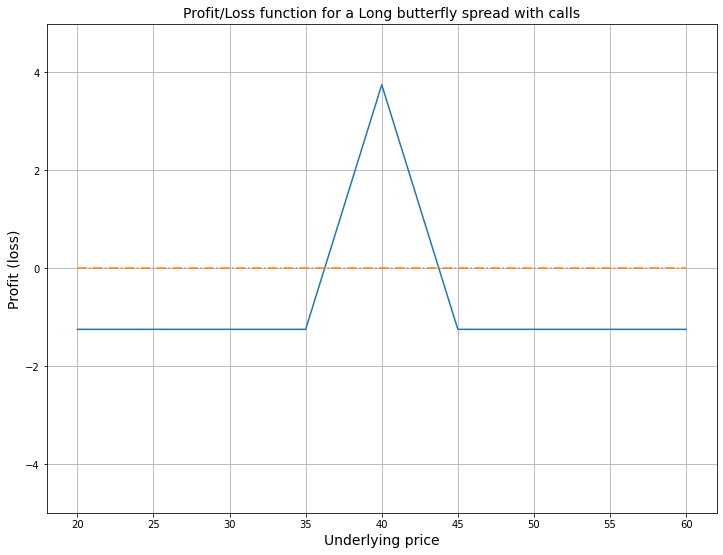

In [15]:
s = np.arange(20,65,5)
x1 = 35; x2 = 40; x3 = 45; 
c1 = 6.40; c2 = 3.30; c3 = 1.45
y = v_pl_call(s, x1, c1) - 2 * v_pl_call(s, x2, c2) + v_pl_call(s, x3, c3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-5,5)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Long butterfly spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Long butterfly spread with puts

### Strategy

### When to use

### Max profit

### Max risk

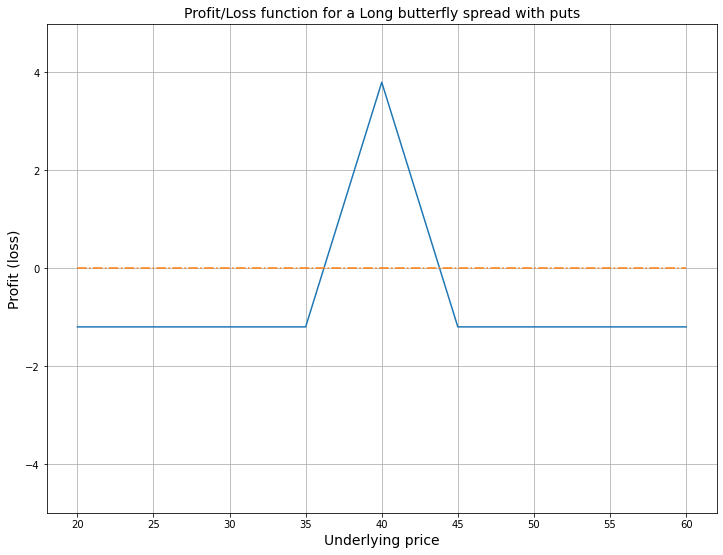

In [16]:
s = np.arange(20,65,5)
x1 = 35; x2 = 40; x3 = 45; 
p1 = 6.25; p2 = 3.15; p3 = 1.25
y = v_pl_put(s, x1, p1) - 2 * v_pl_put(s, x2, p2) + v_pl_put(s, x3, p3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-5,5)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Long butterfly spread with puts", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Long Christmas tree spread with calls

### Strategy

### When to use

### Max profit

### Max risk

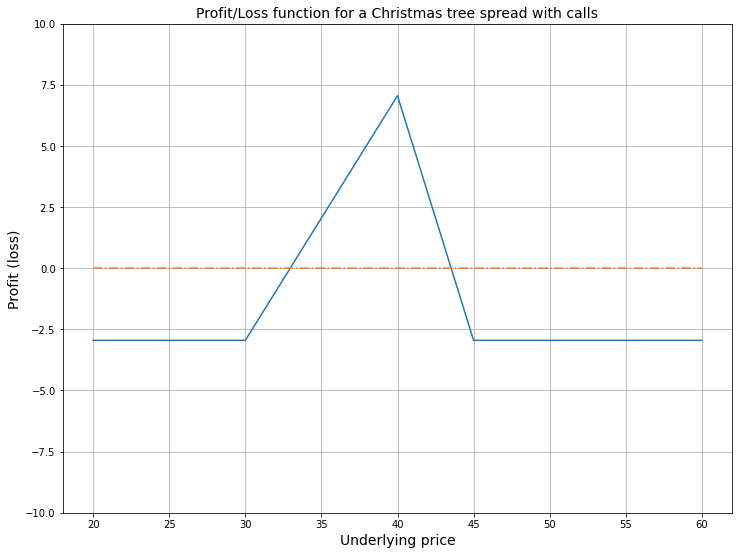

In [17]:
s = np.arange(20,65,5)
x1 = 30; x2 = 40; x3 = 45; 
c1 = 8.40; c2 = 2.35; c3 = 0.80
y = v_pl_call(s, x1, c1) - 3 * v_pl_call(s, x2, c2) + 2 * v_pl_call(s, x3, c3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-10,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Christmas tree spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Long Christmas tree spread with puts

### Strategy

### When to use

### Max profit

### Max risk

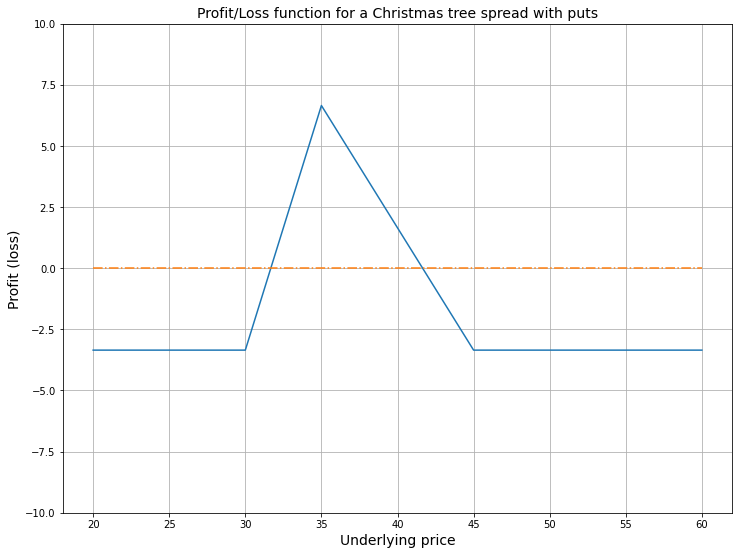

In [18]:
s = np.arange(20,65,5)
x1 = 30; x2 = 35; x3 = 45; 
p1 = 0.7; p2 = 2.10; p3 = 8.25
y = 2 * v_pl_put(s, x1, p1) - 3 * v_pl_put(s, x2, p2) + v_pl_put(s, x3, p3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-10,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Christmas tree spread with puts", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Long calendar spread with calls

### Strategy

### When to use

### Max profit

### Max risk

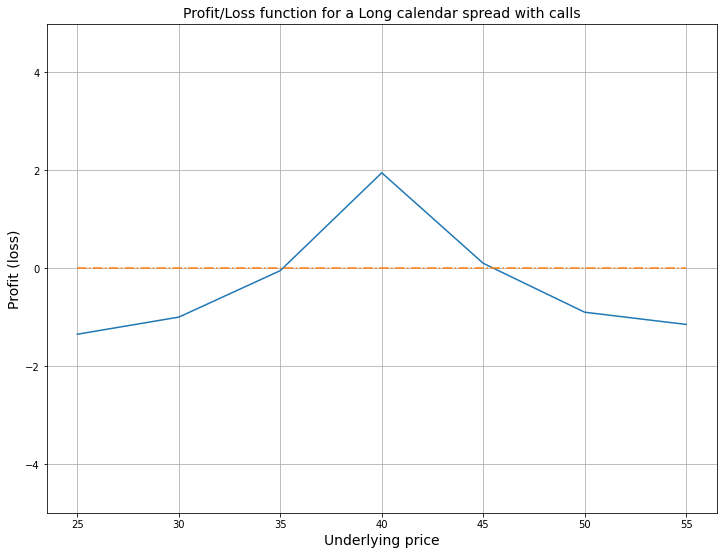

In [19]:
s = np.arange(25,60,5)
x = 40; c1 = 3.35; c2 = 4.75
y = np.array([-4.70, -4.35, -3.4, -1.4, 1.75, 5.75, 10.50]) - v_pl_call(s, x, c1)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-5,5)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Long calendar spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

# Volatility Strategies

## Long Straddle

### Strategy

The straddle option strategy involves either buying the exact same strike price call and put or selling the exact same strike price call and put of a given an underlying security.

### When to use it

When you're buying both a call and a put at the same strike price you're trading a long Staddle, while if you're selling both a call and a put a the strike price you're trading a short Straddle. 

Long straddle are often traded when traders predict high volatility for the underlying, ....

### Max Profit

### Max risk

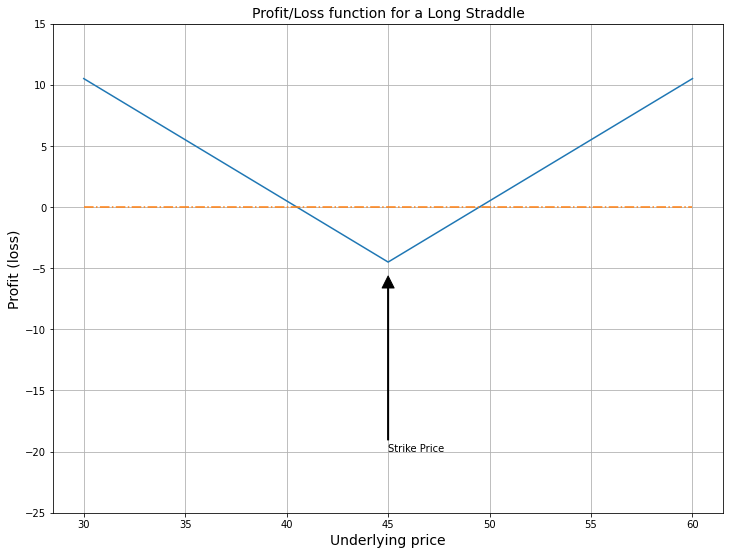

In [20]:
s = np.arange(30,65,5)
x = 45; p = 2.5; c = 2
y = v_pl_call(s, x, c) + v_pl_put(s, x, p) 
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-25,15)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Long Straddle", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.annotate('Strike Price', xy=(45,-(p+c) - 1), xytext=(45,-20), arrowprops=dict(
    facecolor='black',
    shrink=0.01, 
    width=1),)
plt.grid(True)
plt.show()

## Long Strangle

### Strategy

The straddle option strategy involves either buying the exact same strike price call and put or selling the exact same strike price call and put of a given an underlying security.

### When to use it

When you're buying both a call and a put at the same strike price you're trading a long Staddle, while if you're selling both a call and a put a the strike price you're trading a short Straddle. 

Long straddle are often traded when traders predict high volatility for the underlying, ....

### Max Profit

### Max risk

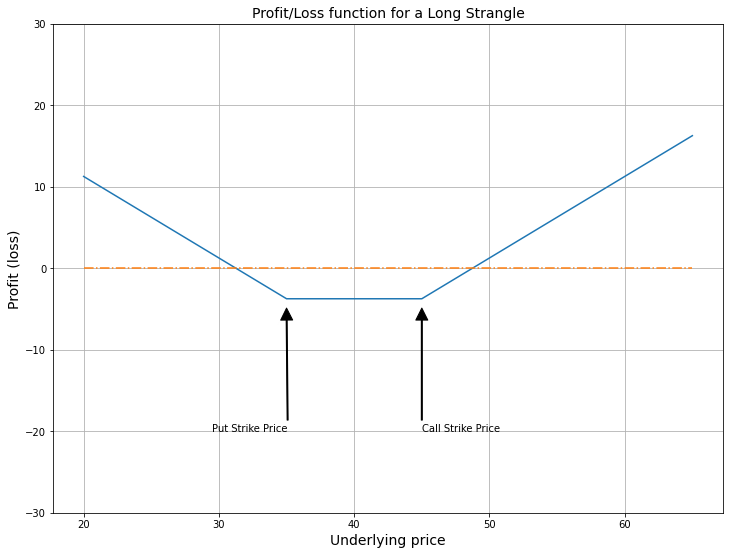

In [21]:
s = np.arange(20,70,5)
x1 = 45; x2 = 35; p = 2; c = 1.75
y = v_pl_call(s, x1, c) + v_pl_put(s, x2, p) 
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-30,30)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Long Strangle", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.annotate('Call Strike Price', xy=(45,-(p+c) - 1), xytext=(45,-20), arrowprops=dict(
    facecolor='black',
    shrink=0.01, 
    width=1),)
plt.annotate('Put Strike Price', xy=(35,-(p+c) - 1), xytext=(29.5,-20), arrowprops=dict(
    facecolor='black',
    shrink=0.01, 
    width=1),)
plt.grid(True)
plt.show()

## Short butterfly spread with puts

### Strategy

### When to use

### Max profit

### Max risk

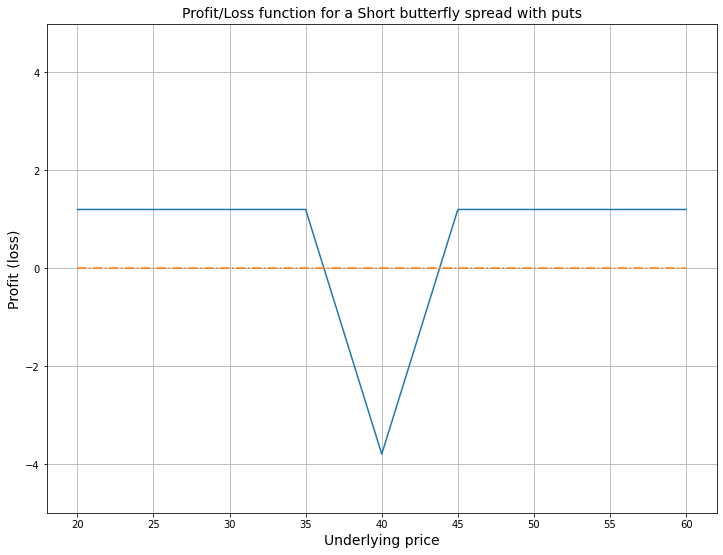

In [22]:
s = np.arange(20,65,5)
x1 = 35; x2 = 40; x3 = 45; 
p1 = 6.25; p2 = 3.15; p3 = 1.25
y = - v_pl_put(s, x1, p1) + 2 * v_pl_put(s, x2, p2) - v_pl_put(s, x3, p3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-5,5)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short butterfly spread with puts", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short butterfly spread with calls

### Strategy

### When to use

### Max profit

### Max risk

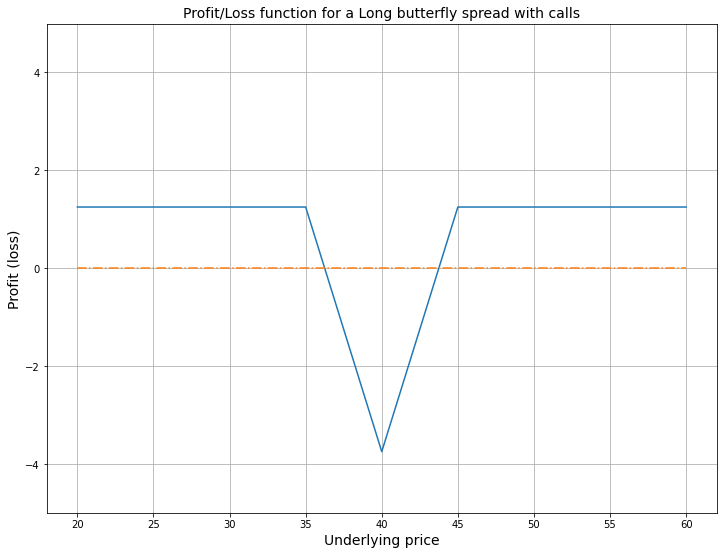

In [23]:
s = np.arange(20,65,5)
x1 = 35; x2 = 40; x3 = 45; 
c1 = 6.40; c2 = 3.30; c3 = 1.45
y = -v_pl_call(s, x1, c1) + 2 * v_pl_call(s, x2, c2) - v_pl_call(s, x3, c3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-5,5)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Long butterfly spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short Christmas tree spread with calls

### Strategy

### When to use

### Max profit

### Max risk

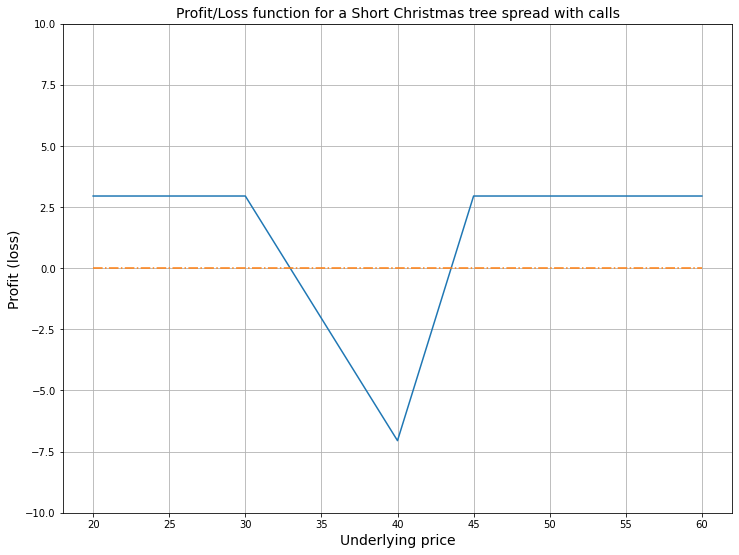

In [24]:
s = np.arange(20,65,5)
x1 = 30; x2 = 40; x3 = 45; 
c1 = 8.40; c2 = 2.35; c3 = 0.80
y = - v_pl_call(s, x1, c1) + 3 * v_pl_call(s, x2, c2) - 2 * v_pl_call(s, x3, c3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-10,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short Christmas tree spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short Christmas tree spread with puts

### Strategy

### When to use

### Max profit

### Max risk

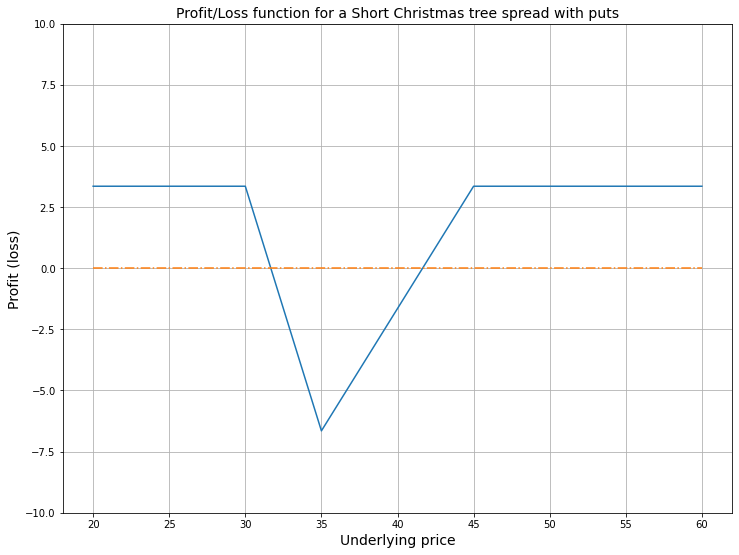

In [25]:
s = np.arange(20,65,5)
x1 = 30; x2 = 35; x3 = 45; 
p1 = 0.7; p2 = 2.10; p3 = 8.25
y = - 2 * v_pl_put(s, x1, p1) + 3 * v_pl_put(s, x2, p2) - v_pl_put(s, x3, p3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-10,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short Christmas tree spread with puts", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short calendar spread with calls

### Strategy

### When to use

### Max profit

### Max risk

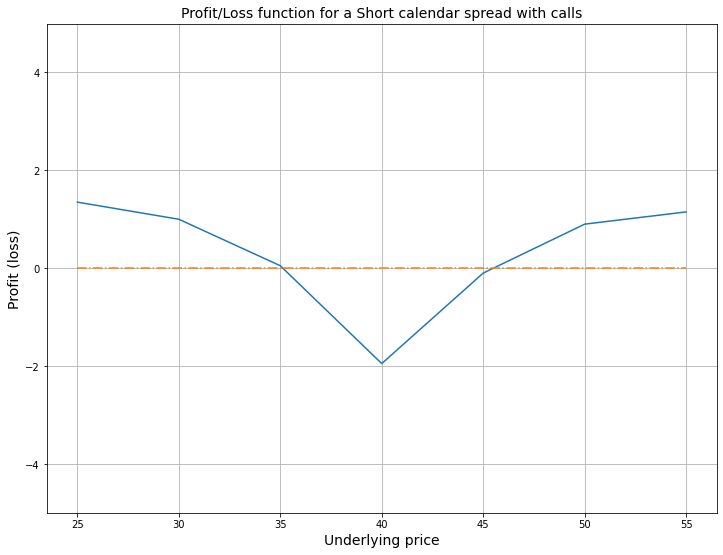

In [26]:
s = np.arange(25,60,5)
x = 40; c1 = 3.35; c2 = 4.75
y = - np.array([-4.70, -4.35, -3.4, -1.4, 1.75, 5.75, 10.50]) + v_pl_call(s, x, c1)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-5,5)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short calendar spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short condor spread with calls

### Strategy

### When to use

### Max profit

### Max risk

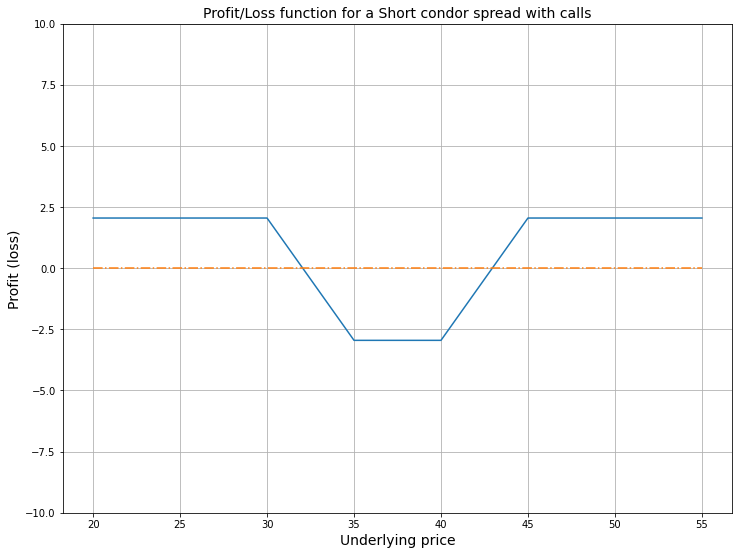

In [27]:
s = np.arange(20,60,5)
x1 = 30; x2 = 35; x3 = 40; x4 = 45; 
c1 = 8.40; c2 = 4.80; c3 = 2.35; c4 = 0.80
y = - v_pl_call(s, x1, c1) + v_pl_call(s, x2, c2) + \
    v_pl_call(s, x3, c3) - v_pl_call(s, x4, c4) 
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-10,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short condor spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short condor spread with puts

### Strategy

### When to use

### Max profit

### Max risk

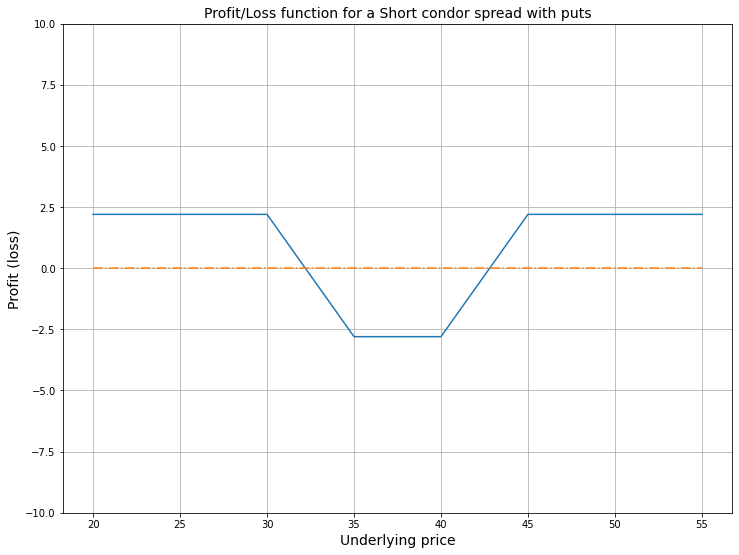

In [28]:
s = np.arange(20,60,5)
x1 = 30; x2 = 35; x3 = 40; x4 = 45; 
p1 = 8.25; p2 = 4.65; p3 = 2.10; p4 = 0.70
y = - v_pl_put(s, x1, p1) + v_pl_put(s, x2, p2) + \
    v_pl_put(s, x3, p3) - v_pl_put(s, x4, p4) 
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-10,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short condor spread with puts", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

# Bearish Strategies

## Bear Put Spread

### Strategy

### When to use it

### Max Profit

### Max risk

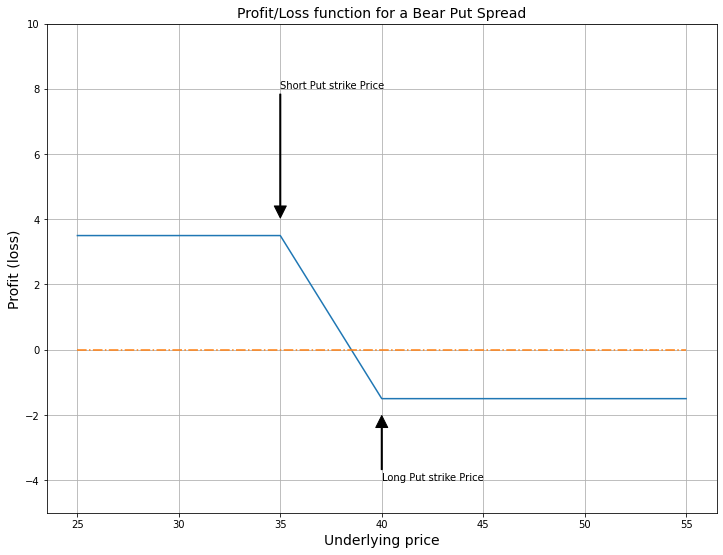

In [39]:
s = np.arange(25,60,5)
x1 = 40; x2 = 35; p1 = 3; p2 = 1.5
y = v_pl_put(s, x1, p1) - v_pl_put(s, x2, p2)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Bear Put Spread", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.annotate('Long Put strike Price', xy=(x1,(p1-p2)-3.5), xytext=(x1,-4), arrowprops=dict(
    facecolor='black',
    shrink=0.01, 
    width=1),)
plt.annotate('Short Put strike Price', xy=(x2,4), xytext=(x2,8), arrowprops=dict(
    facecolor='black',
    shrink=0.01, 
    width=1),)
plt.grid(True)
plt.show()

## Bear call Spread

### Strategy

The straddle option strategy involves either buying the exact same strike price call and put or selling the exact same strike price call and put of a given an underlying security.

### When to use it

When you're buying both a call and a put at the same strike price you're trading a long Staddle, while if you're selling both a call and a put a the strike price you're trading a short Straddle. 

Long straddle are often traded when traders predict high volatility for the underlying, ....

### Max Profit

### Max risk

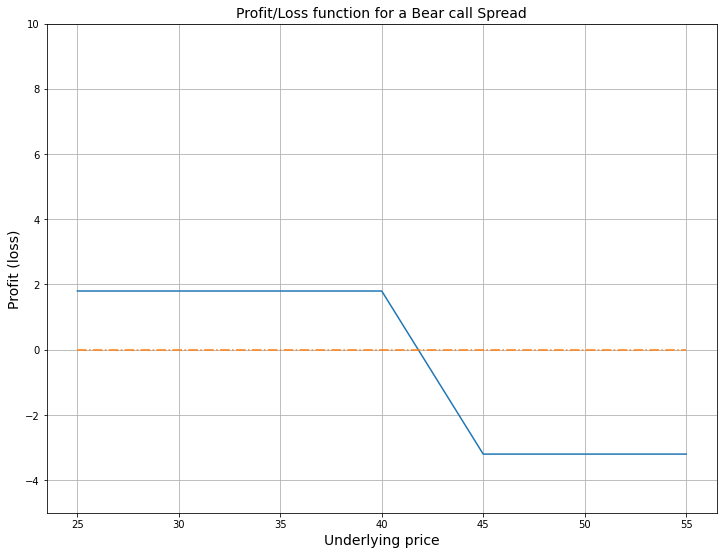

In [30]:
s = np.arange(25,60,5)
x1 = 40; x2 = 45; c1 = 3.30; c2 = 1.5
y = -v_pl_call(s, x1, c1) + v_pl_call(s, x2, c2)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Bear call Spread", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
# plt.annotate('Long Put strike Price', xy=(x1,(p1-p2)-1.5), xytext=(x1,-4), arrowprops=dict(
#     facecolor='black',
#     shrink=0.01, 
#     width=1),)
# plt.annotate('Short Put strike Price', xy=(x2,4.75), xytext=(x2,8), arrowprops=dict(
#     facecolor='black',
#     shrink=0.01, 
#     width=1),)
plt.grid(True)
plt.show()

## 1x2 ratio volatility spread with puts

### Strategy

### When to use

### Max profit

### Max risk

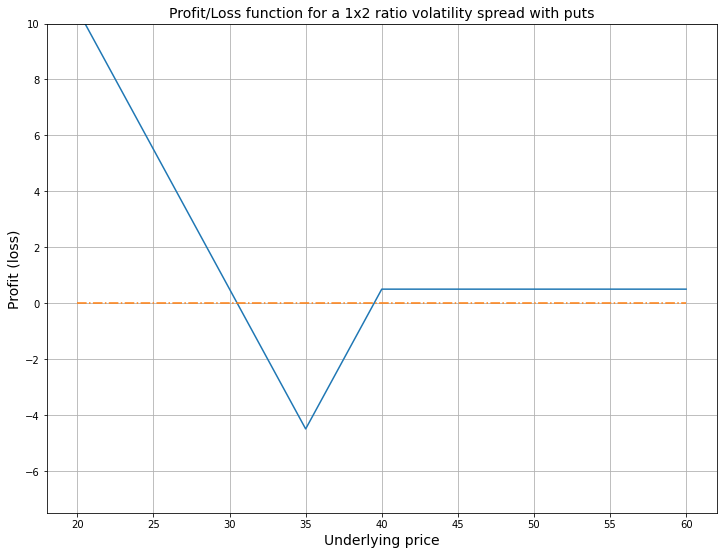

In [31]:
s = np.arange(20,65,5)
x1 = 35; x2 = 40;
p1 = 1.5; p2 = 3.5;
y = 2 * v_pl_put(s, x1, p1) - v_pl_put(s, x2, p2)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-7.5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a 1x2 ratio volatility spread with puts", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short skip-strike butterfly spread with puts

### Strategy

### When to use

### Max profit

### Max risk

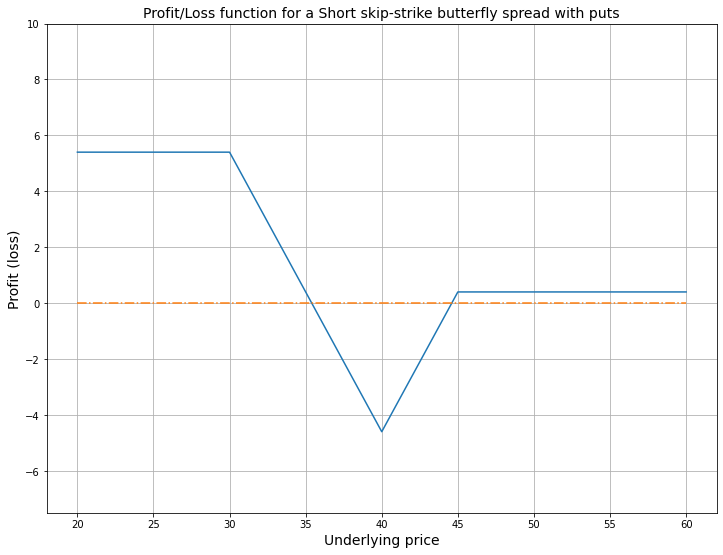

In [41]:
s = np.arange(20,65,5)
x1 = 30; x2 = 40; x3 = 45
p1 = 1.45; p2 = 4.65; p3 = 8.25
y = 2 * v_pl_put(s, x2, p2) - v_pl_put(s, x1, p1) - v_pl_put(s, x3, p3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-7.5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short skip-strike butterfly spread with puts", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short diagonal spread with calls

### Strategy

### When to use

### Max profit

### Max risk

TODO

# Bullish Strategies

## Bull call spread

### Strategy

### When to use

### Max profit

### Max risk

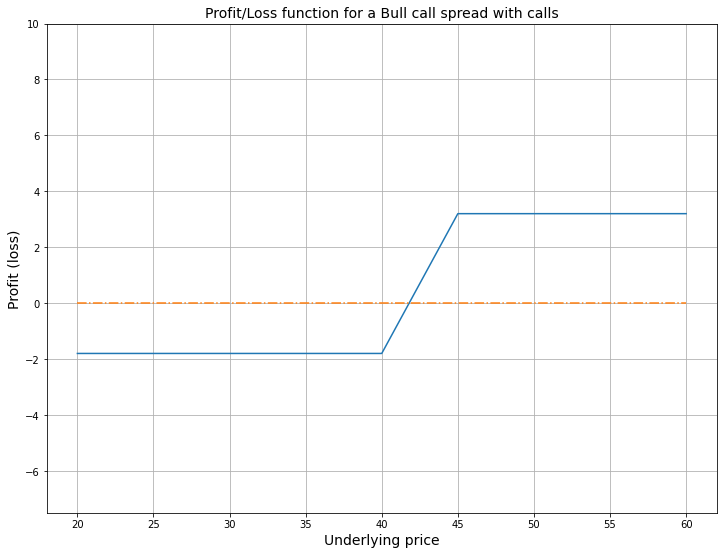

In [42]:
s = np.arange(20,65,5)
x1 = 40; x2 = 45;
c1 = 3.30; c2 = 1.5;
y = v_pl_call(s, x1, c1) - v_pl_call(s, x2, c2)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-7.5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Bull call spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Bull put spread

### Strategy

### When to use

### Max profit

### Max risk

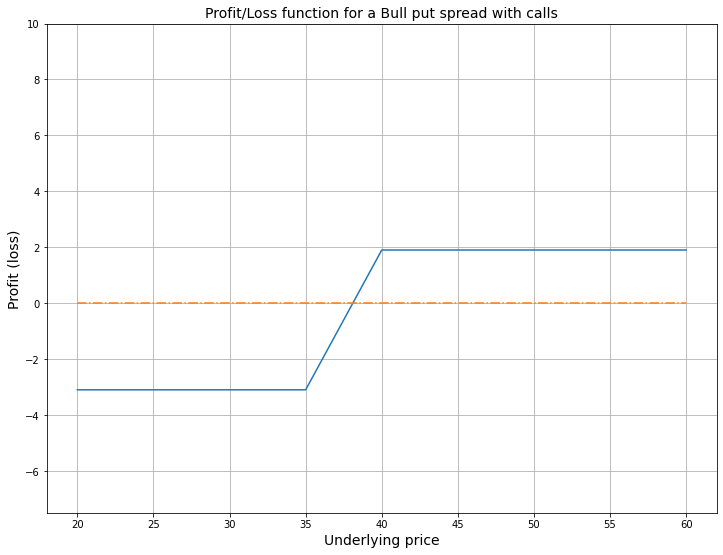

In [43]:
s = np.arange(20,65,5)
x1 = 40; x2 = 35;
c1 = 3.20; c2 = 1.3;
y = - v_pl_put(s, x1, c1) + v_pl_put(s, x2, c2)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-7.5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Bull put spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## 1x2 ratio volatility spread with calls

### Strategy

### When to use

### Max profit

### Max risk

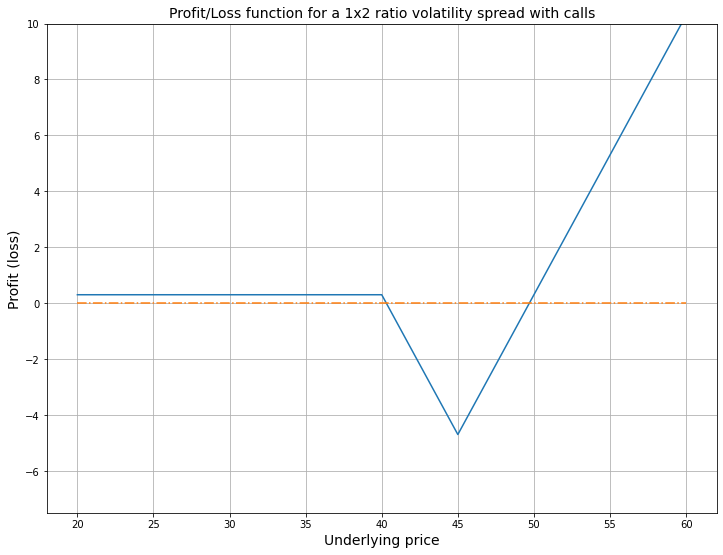

In [32]:
s = np.arange(20,65,5)
x1 = 40; x2 = 45;
c1 = 3.30; c2 = 1.5;
y = - v_pl_call(s, x1, c1) + 2 * v_pl_call(s, x2, c2)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-7.5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a 1x2 ratio volatility spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()

## Short skip-strike butterfly spread with calls


### Strategy

### When to use

### Max profit

### Max risk

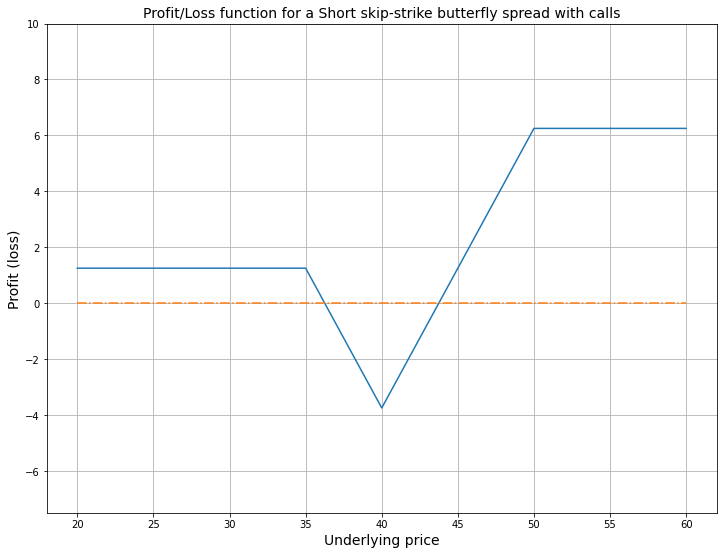

In [47]:
s = np.arange(20,65,5)
x1 = 35; x2 = 40; x3 = 50
c1 = 3.30; c2 = 1.5; c3 = 0.95
y = - v_pl_call(s, x1, c1) + 2 * v_pl_call(s, x2, c2) - v_pl_call(s, x3, c3)
y2 = np.zeros(len(s))

plt.figure(figsize = (12,9))
plt.ylim(-7.5,10)
plt.plot(s,y) 
plt.plot(s,y2,'-.')
plt.title("Profit/Loss function for a Short skip-strike butterfly spread with calls", fontdict=font) 
plt.xlabel('Underlying price', fontdict=font)
plt.ylabel('Profit (loss)', fontdict=font)
plt.grid(True)
plt.show()